In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import subprocess

from nistats import hemodynamic_models

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)

In [42]:
# Directory for PPI analysis
path_out = os.path.join(path_root, 
                        'data/main_fmri_study/derivatives/ppi')
os.makedirs(path_out, exist_ok=True)

# Timeseries directory
path_timeries = os.path.join(path_out, 'timeseries')

# Load timeseries
time_series_all = np.load(os.path.join(path_timeries, 'time_series_clean_all.npy'))

### Sample and store hemodynamic response function

In [46]:
hrf_spm = hemodynamic_models.spm_hrf(t_r, oversampling=1, 
                                     time_length=t_r*20, onset=0.0)
hrf_glover = hemodynamic_models.glover_hrf(t_r, oversampling=1,
                                        time_length=t_r*20, onset=0.0)

pd.Series(hrf_spm).to_csv(os.path.join(path_timeries, 'spmHRF.1D'), index=False, header=False)
pd.Series(hrf_glover).to_csv(os.path.join(path_timeries, 'gloverHRF.1D'), index=False, header=False)

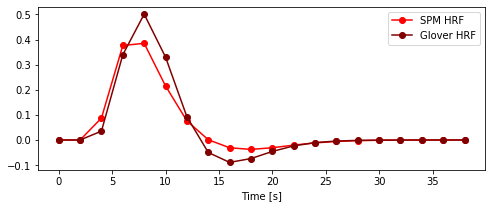

In [45]:
n_vol_hrf = 20

fig, ax = plt.subplots(figsize=(8, 3), facecolor='w')

ax.plot(np.arange(0, n_vol_hrf*2, t_r), hrf_spm[:20], '-o', color='r', label='SPM HRF')
ax.plot(np.arange(0, n_vol_hrf*2, t_r), hrf_glover[:20], '-o', color='maroon', label='Glover HRF')
ax.set_xlabel('Time [s]')
ax.legend()
plt.show()

In [13]:
path_hrf = os.path.join(path_timeries, 'spmHRF.1D')

ts = time_series_all[0, 0, :, 0]

pd.Series(ts).to_csv('ts.1D', index=False, header=False)

cmd = f'3dTfitter -RHS ts.1D -FALTUNG {path_hrf} ts_deco 012 0'
subprocess.call(cmd, shell=True)

ts_deco = np.loadtxt('ts_deco.1D')

0

In [53]:
len(ts_deco)

730